In [1]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.autoencoder import AutoencoderLightningModule
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-02/18-43-45" # 6 epochs 
BASE_DIR = "/home/ec2-user/outputs-proteoscope/cytoself/2023-08-10/04-57-13" # 1 epoch epoch=6-step=69500
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)

    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim
    )
    pdm.setup()

    clm = AutoencoderLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        num_class=pdm.num_class,
    )

    clm.vae.to('cuda')
    clm.eval()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/tmp/ipykernel_12602/3241269805.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/cytoself/2023-08-10/04-57-13/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/datamodule.py:40: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)


## Reconstruct val images

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
from piqa import SSIM

i = 0
inputs = []
reconstructions = []
ssim = SSIM(n_channels=1).to('cuda')
ssim_scores_pro = []
ssim_scores_nuc = []

dl = pdm.val_dataloader(novel_proteins=False, shuffle=False)
with torch.no_grad():
    for batch in tqdm(dl):
        input_images = batch['image'].to('cuda')
        output_images = clm.sample(input_images)
        ssim_scores_pro.append([ssim(input_images[:, 0].unsqueeze_(1), torch.clip(output_images[:, 0].unsqueeze_(1), 0, 1)).detach().cpu().numpy()])
        ssim_scores_nuc.append([ssim(input_images[:, 1].unsqueeze_(1), torch.clip(output_images[:, 1].unsqueeze_(1), 0, 1)).detach().cpu().numpy()])
        inputs.append(input_images.detach().cpu().numpy())
        reconstructions.append(output_images.detach().cpu().numpy())
inputs = np.concatenate(inputs, axis=0)
reconstructions = np.concatenate(reconstructions, axis=0)
ssim_scores_pro = np.concatenate(ssim_scores_pro, axis=0)
ssim_scores_nuc = np.concatenate(ssim_scores_nuc, axis=0)
true_names = np.array(dl.dataset.labels['name'])

100%|██████████| 1435/1435 [04:41<00:00,  5.10it/s]


In [ ]:
print(ssim_scores_pro.mean())
print(ssim_scores_nuc.mean())

0.9374166
0.95621836


In [ ]:
from proteoscope.plotting import browse_reconstructions, merge_prot_nuc


browse_reconstructions(inputs[:, 0], reconstructions[:, 0], true_names)

interactive(children=(Dropdown(description='name', options=('AAMP', 'AATF', 'ABCE1', 'ABR', 'ACAP2', 'ACLY', '…

## Merged nuclei view

In [ ]:
true_merged = merge_prot_nuc(inputs[:1000], percentiles=[0.1, 99.9])
predicted_merged = merge_prot_nuc(reconstructions[:1000], percentiles=[0.1, 99.9])
true_names_merged = true_names[:1000]

In [ ]:
browse_reconstructions(true_merged, predicted_merged, true_names_merged)

interactive(children=(Dropdown(description='name', options=('ACTB', 'AHSA1', 'BAG4', 'BAG6', 'CDC37', 'DNAJA1'…

## Generate ALL latents

In [3]:
# import torch
# from tqdm import tqdm
# import zarr
# from os.path import join
# import numpy as np


# dl = pdm.predict_dataloader()

# datapath = "/home/ec2-user/autoencoder-data/"
# zarr_path = join(datapath, "full_embeddings_2.zarr")

# latents_shape = (16, 12, 12)
# shape = (len(dl.dataset),) + latents_shape
# chunks = (100, None, None, None)

# z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)

# i = 0
# with torch.no_grad():
#     for batch in tqdm(dl):
#         emb = clm.encode(batch['image'].to('cuda'))
#         z[i:i+len(emb)] = emb.detach().cpu().numpy()
#         i = i + len(emb)

## Generate umap

In [ ]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/autoencoder-data/"
zarr_path = join(datapath, "full_embeddings_2.zarr")

z = zarr.open(zarr_path, mode="r")

In [11]:
labels = pdm.val_images_dataset.labels
latents = z.get_orthogonal_selection(list(labels.index))
latents = latents.reshape(latents.shape[0], -1)

In [25]:
print(latents.max())
print(latents.min())

10.501887321472168
-7.183016777038574


In [ ]:
# names_train_avg = np.unique(names_train)
# embeddings_train_avg = []

# for name in names_train_avg:
#     keep = names_train == name
#     embeddings_train_avg.append(np.median(embeddings_train[keep], axis=0))
# embeddings_train_avg = np.array(embeddings_train_avg)

In [51]:
names = labels['name'].unique()
latents_avg = []

for name in tqdm(names):
    keep = labels['name'] == name
    latents_avg.append(np.median(latents[keep], axis=0))
latents_avg = np.array(latents_avg)

  0%|          | 0/1049 [00:00<?, ?it/s]

100%|██████████| 1049/1049 [00:10<00:00, 98.30it/s] 


In [ ]:
# np.save(join(datapath, "names_2_train_avg.npy"), names_train_avg)
# np.save(join(datapath, "embeddings_2_train_avg.npy"), embeddings_train_avg)

# names_train_avg = np.load(join(datapath, "names_2_train_avg.npy"))
# embeddings_train_avg = np.load(join(datapath, "embeddings_2_train_avg.npy"))

In [13]:
# import umap


# n_neighbors = 15
# min_dist = 0.1
# metric = 'euclidean'
# reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
# reducer.fit(latents)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [16]:
from joblib import dump
from joblib import load

# dump(reducer, join(datapath,'umap_model_2a.joblib'))

reducer = load(join(datapath,'umap_model_2a.joblib'))

In [17]:
reduced_latent = reducer.transform(latents)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

In [20]:
localizations = np.array(labels['localization'])
localizations[localizations == ''] = 'other'

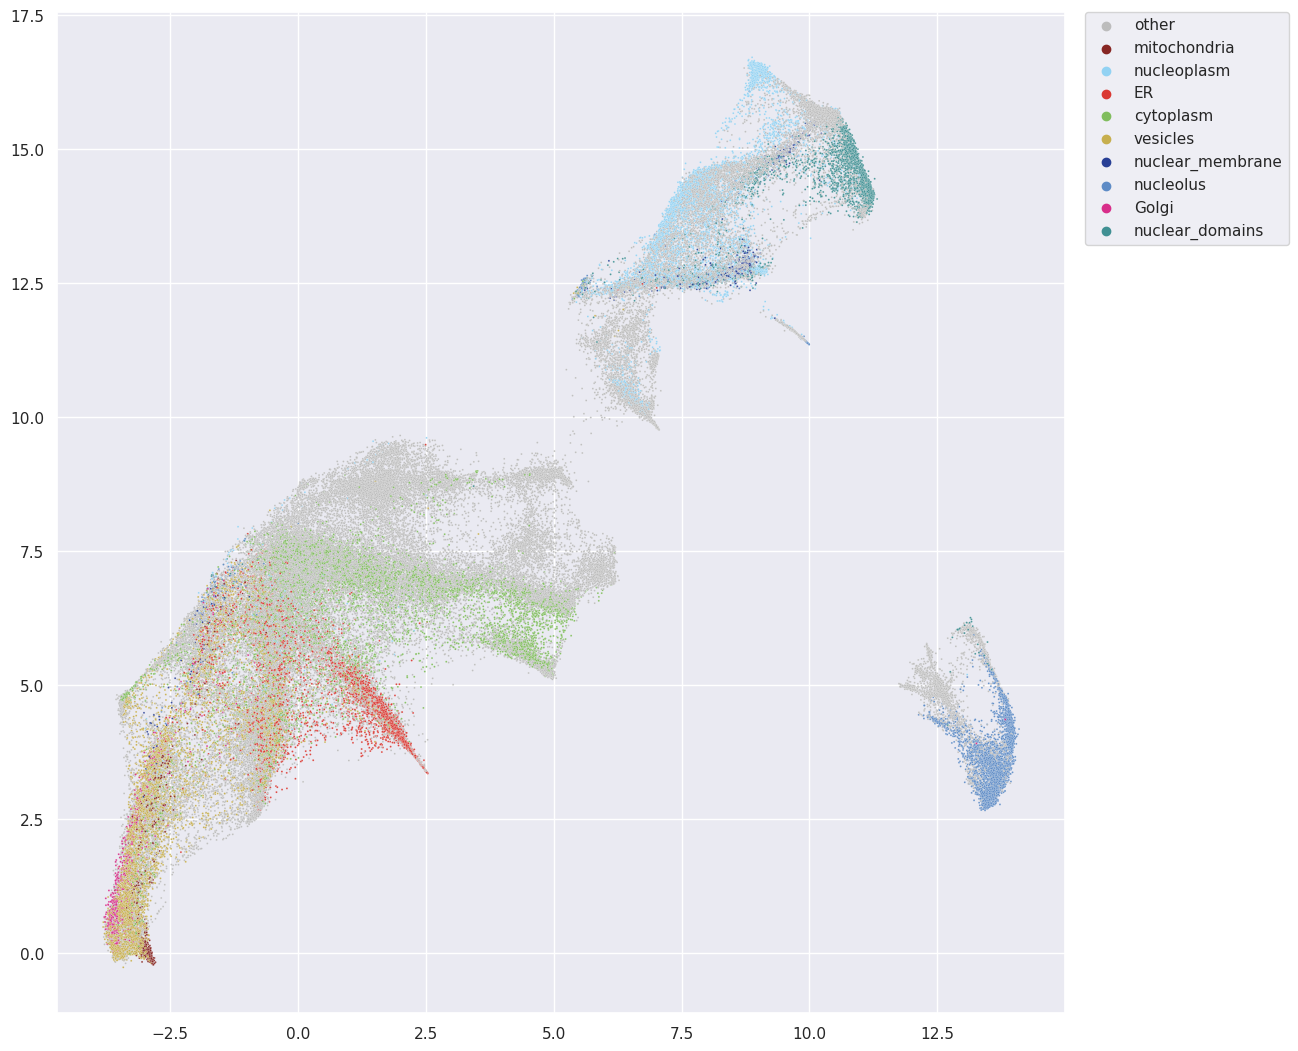

In [21]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_latent[:, 0], y=reduced_latent[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

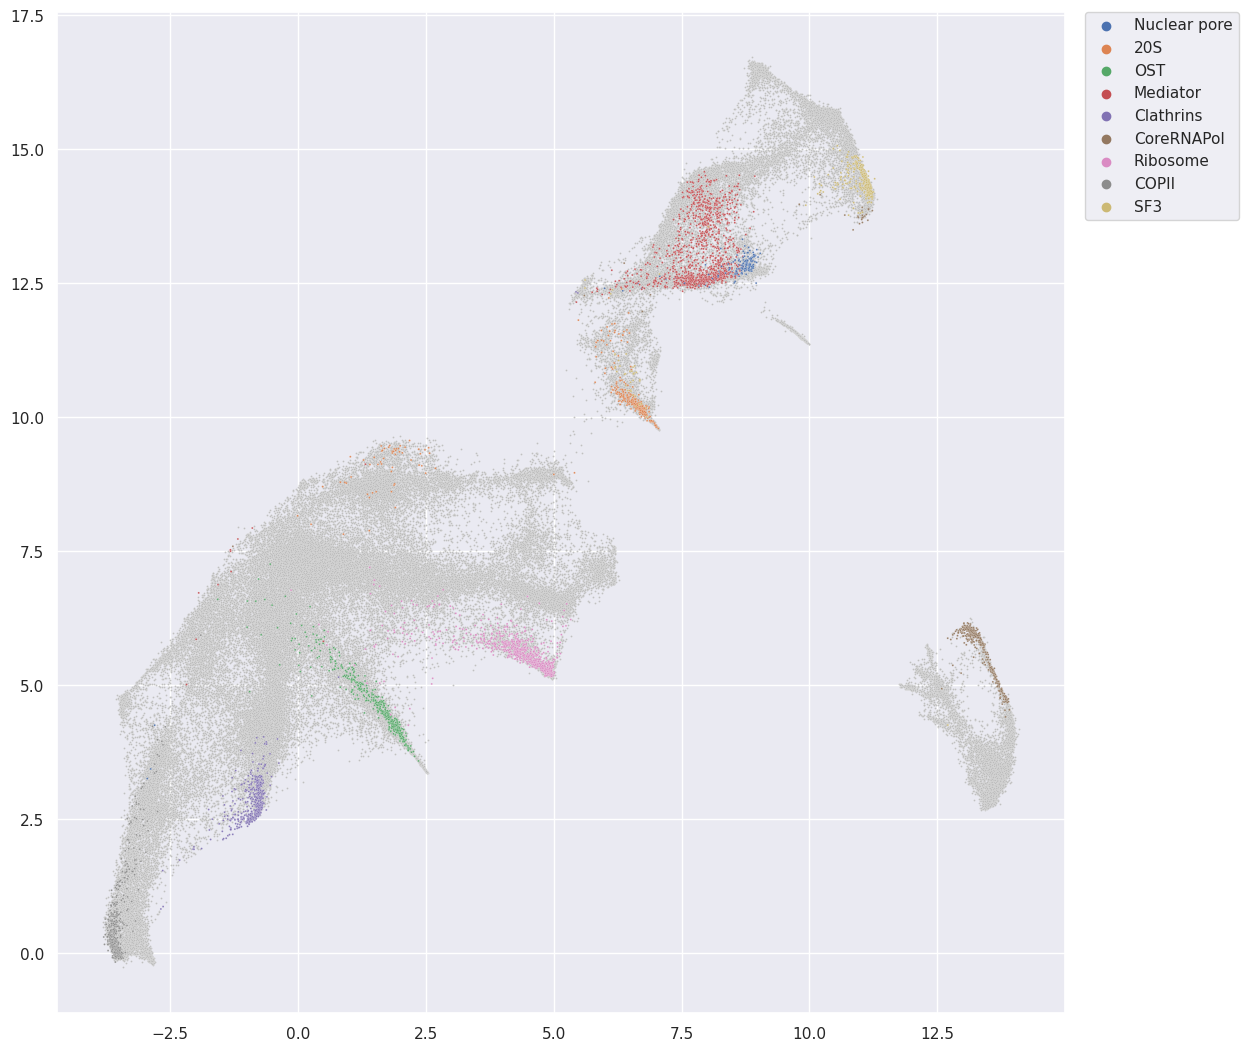

In [26]:
complexes_fig = np.array(labels['complex_fig'])
complexes_fig[complexes_fig == ''] = 'other'
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_latent[other, 0], y=reduced_latent[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_latent[~other, 0], y=reduced_latent[~other, 1], hue=complexes_fig[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

In [ ]:
# sns.set(rc={"figure.figsize":(13, 13)})
# other = complexes_fig != 'Ribosome'
# sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
# re = reduced_embedding[~other]
# n = names[~other]
# p = np.random.permutation(len(n))
# sns.scatterplot(x=re[p, 0], y=re[p, 1], hue=n[p], s=2, alpha=0.9)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
# plt.xlim([5, 10])
# plt.ylim([16.5, 21.5])

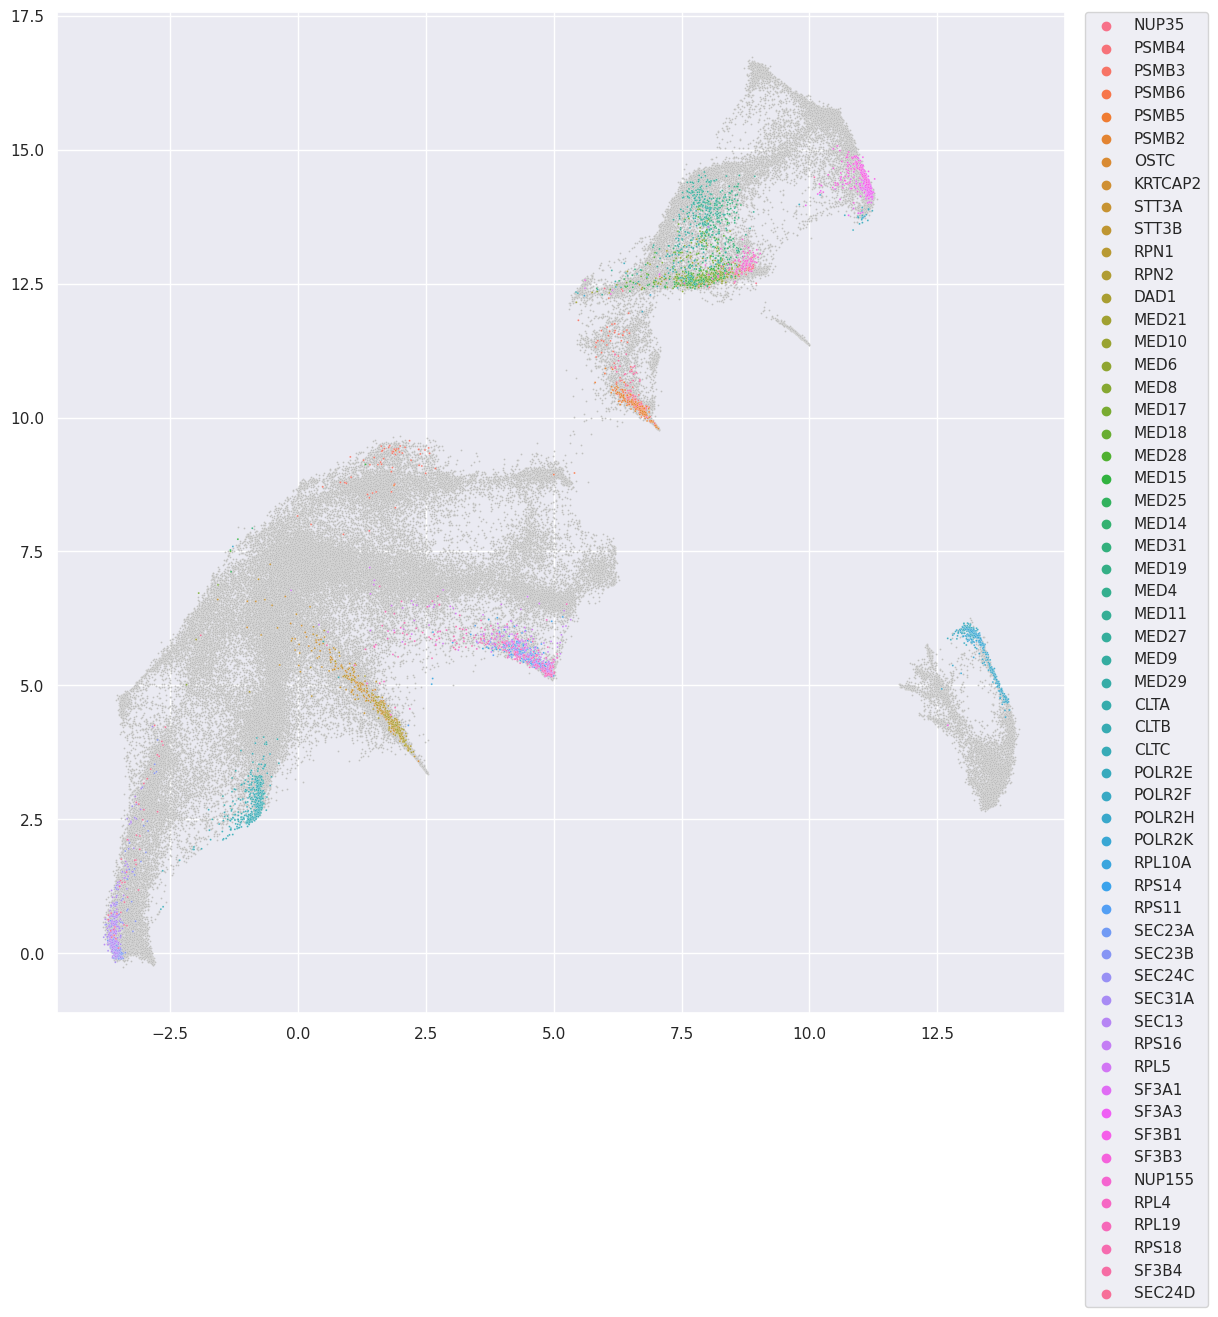

In [28]:
names = np.array(labels['name'])
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_latent[other, 0], y=reduced_latent[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_latent[~other, 0], y=reduced_latent[~other, 1], hue=names[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

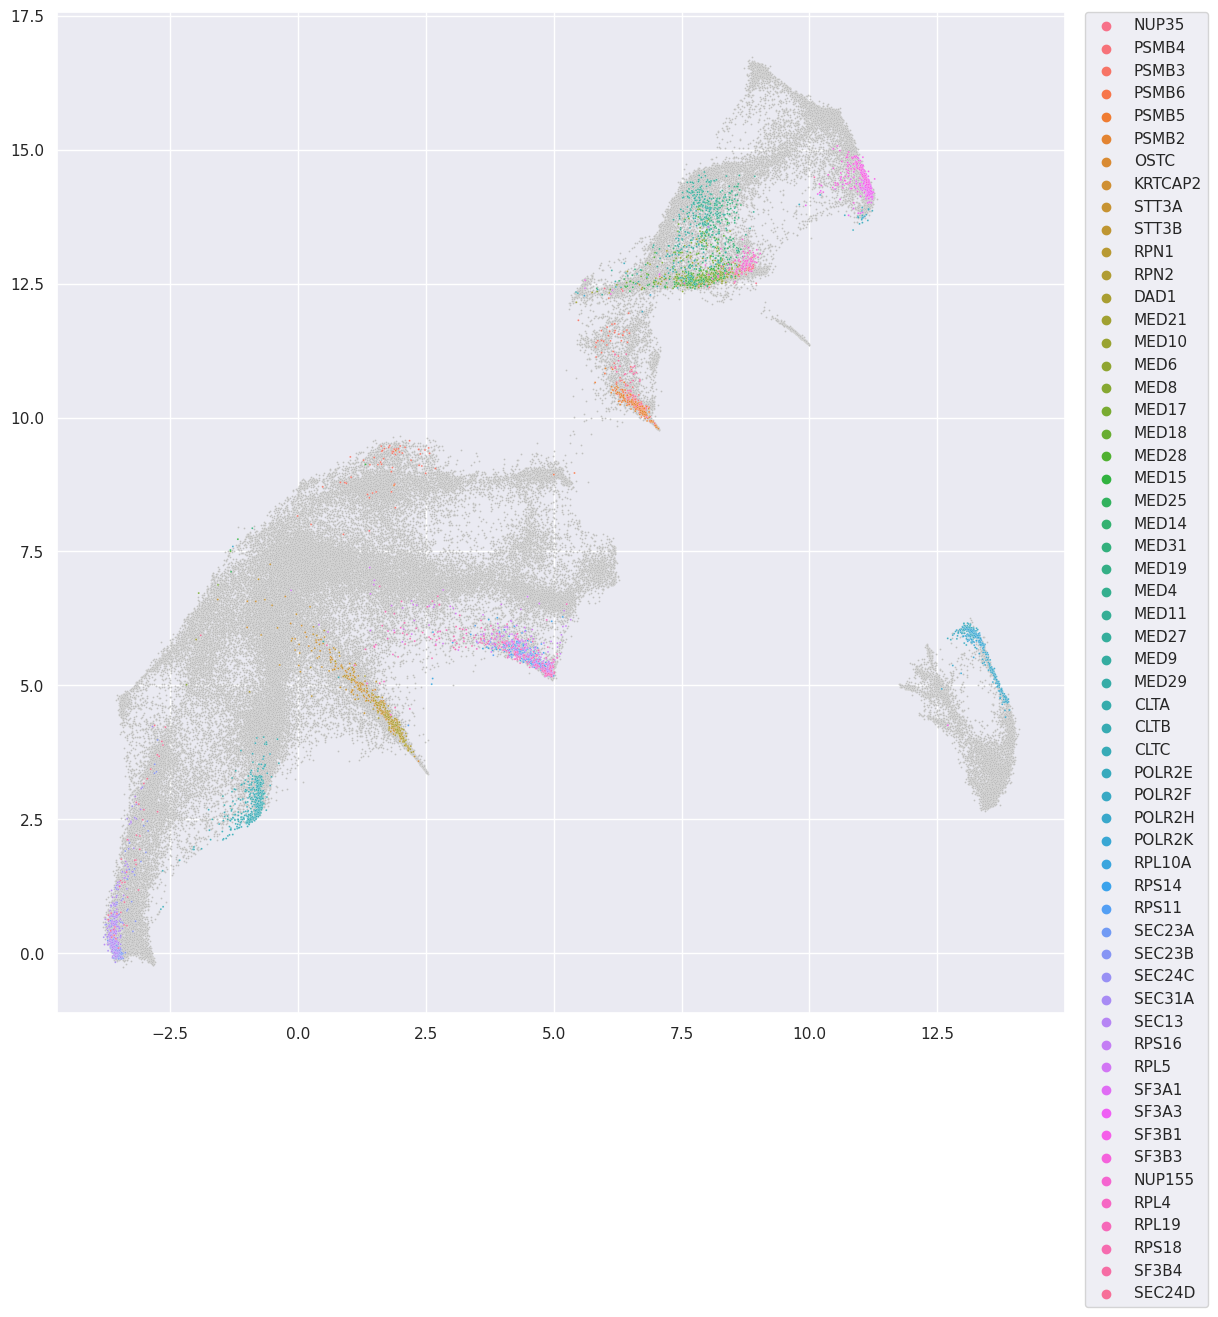

In [29]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_latent[other, 0], y=reduced_latent[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_latent[~other, 0], y=reduced_latent[~other, 1], hue=names[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

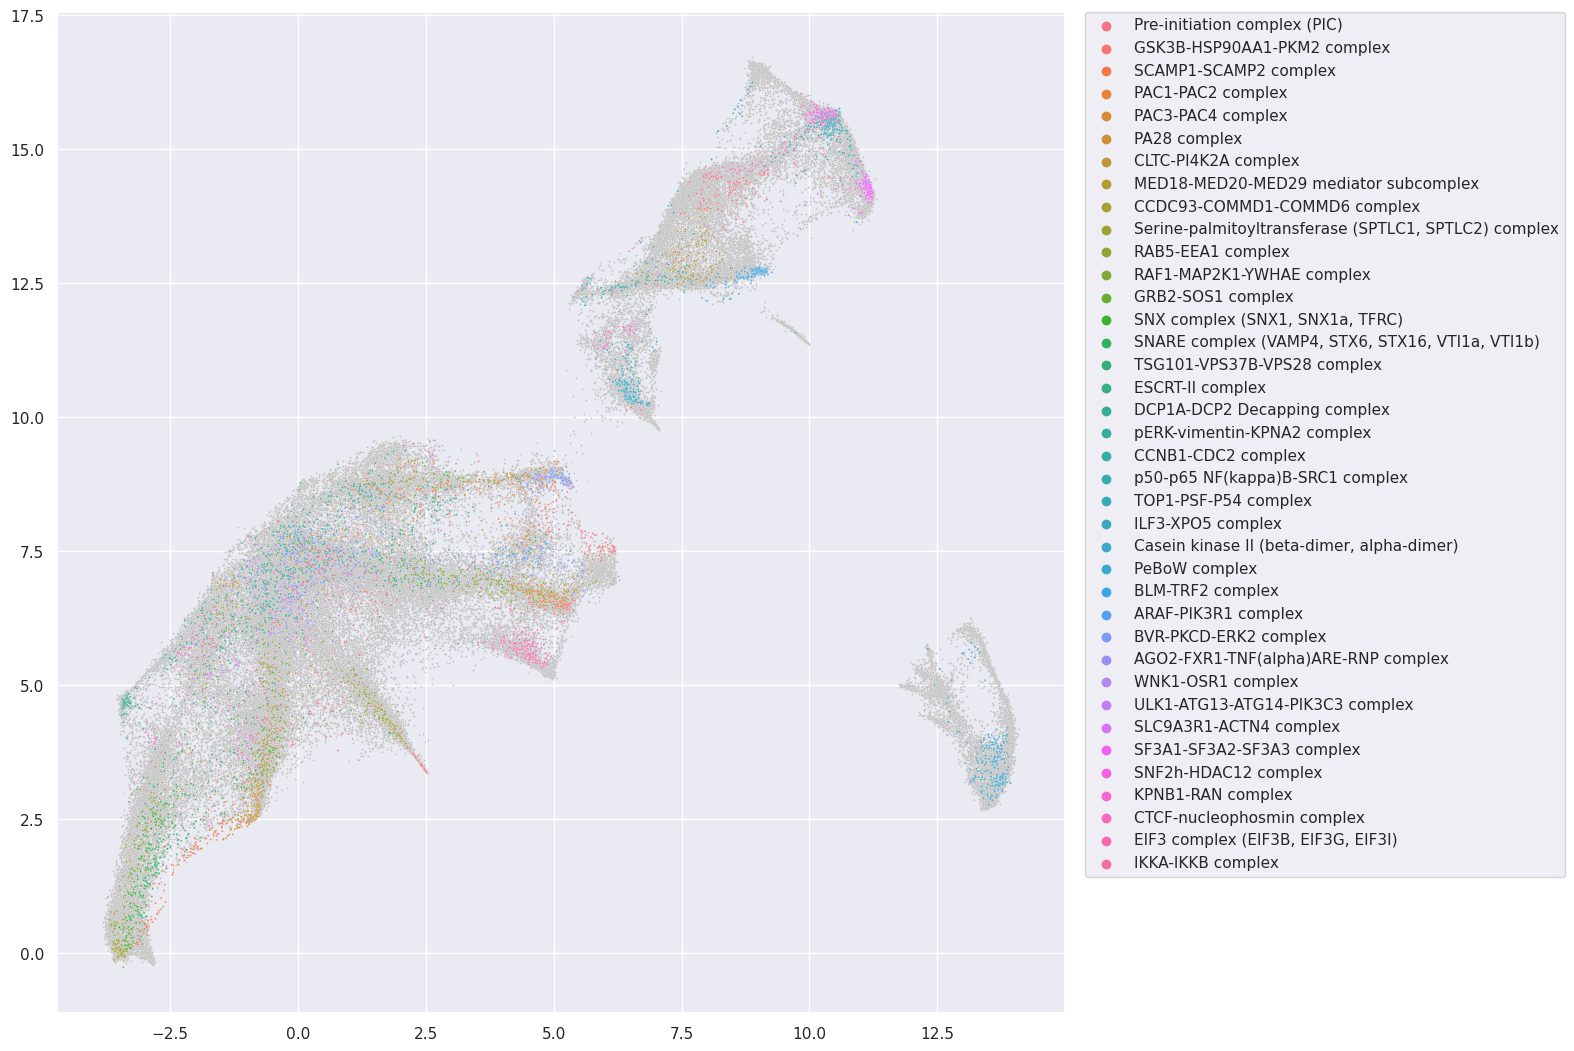

In [30]:
complexes = np.array(labels['complex'])
complexes[complexes == ''] = 'other'
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes == 'other'
sns.scatterplot(x=reduced_latent[other, 0], y=reduced_latent[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_latent[~other, 0], y=reduced_latent[~other, 1], hue=complexes[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### Score clustering

In [31]:
def robust_mean(cluster):
    return np.median(cluster, axis=0)


def robust_std(cluster):
    # Compute the median sum of square distance
    median = robust_mean(cluster)
    std = np.median(np.sqrt(((cluster - median)**2).sum(axis=1)), axis=0)
    return std


def clustering_score(clusters):
    means = [robust_mean(cluster) for cluster in clusters]
    stds = [robust_std(cluster) for cluster in clusters]
    
    # numerator = robust_std(means)
    # denominator = robust_mean(stds)

    numerator = np.std(means, axis=0)
    denominator = np.median(stds, axis=0)


    individual_scores = numerator / denominator
    
    # Assuming that you want to average the individual scores for the final score
    final_score = np.mean(individual_scores)
    
    return final_score

In [32]:
labels = np.unique(localizations)
labels = labels[labels != 'other']
clusters = [reduced_latent[localizations == label] for label in labels]
print(np.mean([len(c) for c in clusters]))
clustering_score(clusters)

3766.222222222222


4.824847

In [33]:
import pandas as pd

X = pd.DataFrame({'complexes':complexes, 'names':names}).drop_duplicates('names')
Z = X.value_counts('complexes')
Z = Z[Z.index != 'other']
labels = list(Z[Z != 1].index)

clusters = [reduced_latent[complexes == label] for label in labels]
print(np.mean([len(c) for c in clusters]))
clustering_score(clusters)

194.57142857142858


3.9135704

## Logistic regression for organelle classification

In [36]:
labels_train = pdm.train_dataset.labels
latents_train = z.get_orthogonal_selection(list(labels_train.index))
latents_train = latents_train.reshape(latents_train.shape[0], -1)

localizations_train = np.array(labels_train['localization'])
localizations_train[localizations_train == ''] = 'other'

In [54]:
latents_train_avg = []

for name in tqdm(names):
    keep = labels_train['name'] == name
    latents_train_avg.append(np.median(latents_train[keep], axis=0))
latents_train_avg = np.array(latents_train_avg)

100%|██████████| 1049/1049 [01:26<00:00, 12.16it/s]


In [37]:
from sklearn.linear_model import LogisticRegression

other = localizations_train == 'other'
X_train = latents_train[~other]
X_train = X_train.reshape((X_train.shape[0], -1))
y_train = localizations_train[~other]

other = localizations == 'other'
X_test = latents[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = localizations[~other]

In [38]:
np.unique(localizations_train)

array(['ER', 'Golgi', 'cytoplasm', 'mitochondria', 'nuclear_domains',
       'nuclear_membrane', 'nucleolus', 'nucleoplasm', 'other',
       'vesicles'], dtype=object)

In [39]:
clf = LogisticRegression(random_state=0, penalty='l2', C=1.0).fit(X_train, y_train)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
from joblib import load
from joblib import dump

# Save the model to a file
dump(clf, join(datapath,'localization_classifier_2a.joblib'))

# # Load the model from the file
# clf = load(join(datapath,'localization_classifier_2a.joblib'))


['/home/ec2-user/autoencoder-data/localization_classifier_2a.joblib']

In [41]:
y_predict = clf.predict(X_test)

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_train)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.8615765872079302


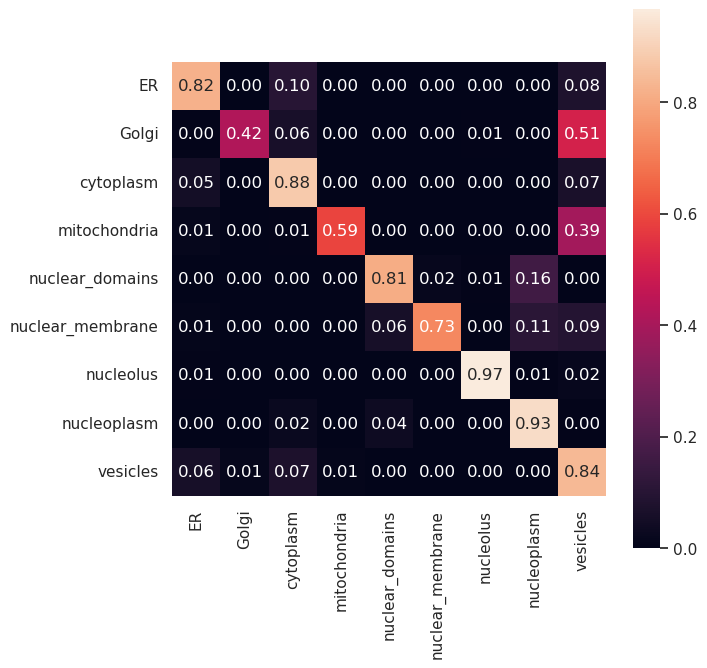

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


## Medians

In [55]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Generate sample data
n = len(names)
Set_A = latents_train_avg.copy()
Set_B = latents_avg.copy()

# Compute pairwise distances for given pairs
given_pair_dists = np.array([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Compute pairwise distances for random pairs (1000 times)
random_pair_dists = []
np.random.seed(0)
for _ in range(1000):
    np.random.shuffle(Set_B)
    random_pair_dists.extend([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

P-value: 0.0


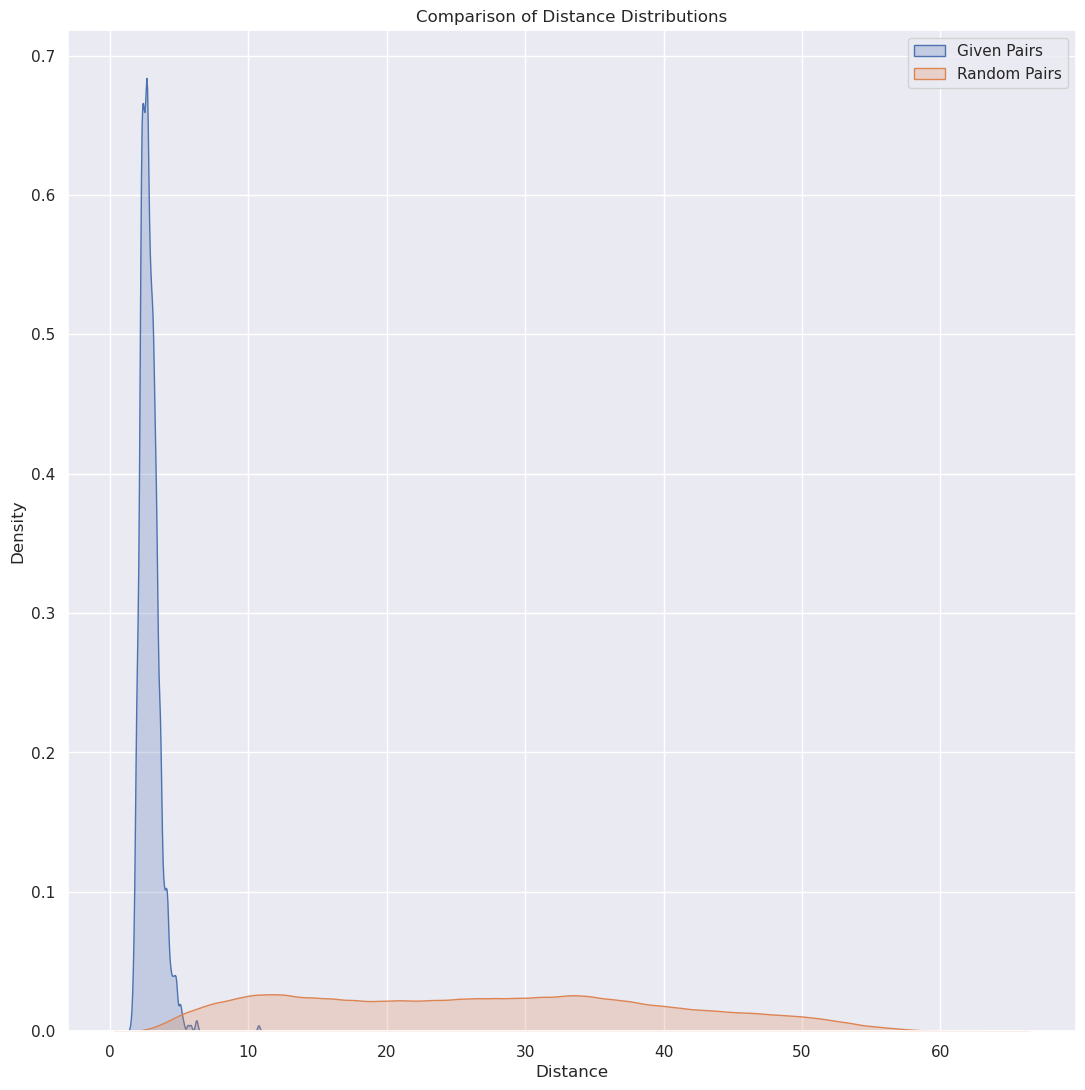

In [56]:
# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

In [ ]:
## Train a simple discriminator on pair of latents using triples (anchor, same, different)
# Evaluate on held validation latents
# Evaluate using diffusion samples

## kNN results

In [ ]:
from annoy import AnnoyIndex

f = embeddings_train_avg[0].size  # dimension of the vector
index = AnnoyIndex(f, metric='euclidean')

# Build the index with vectors from A
for i, v in enumerate(embeddings_train_avg.reshape(embeddings_train_avg.shape[0], -1)):
    index.add_item(i, v)
index.build(100)  # 10 trees, can be adjusted based on precision requirements

True

In [ ]:
k = 500
indices_list = []
for v in embeddings_avg:
    closest_indices = index.get_nns_by_vector(v.reshape(-1), k)
    indices_list.append(closest_indices)
indices_list = np.array(indices_list)

In [ ]:
closest_names = names_train_avg[indices_list]
matches = closest_names == names_train_avg[:, np.newaxis]

In [ ]:
# frac = matches.mean(axis=1)
# frac.mean()
matches[:, 0].mean()

0.9857006673021925

In [ ]:
scores = []
for j in range(1, matches.shape[1]):
    scores.append(matches[:, :j].any(axis=1).mean())

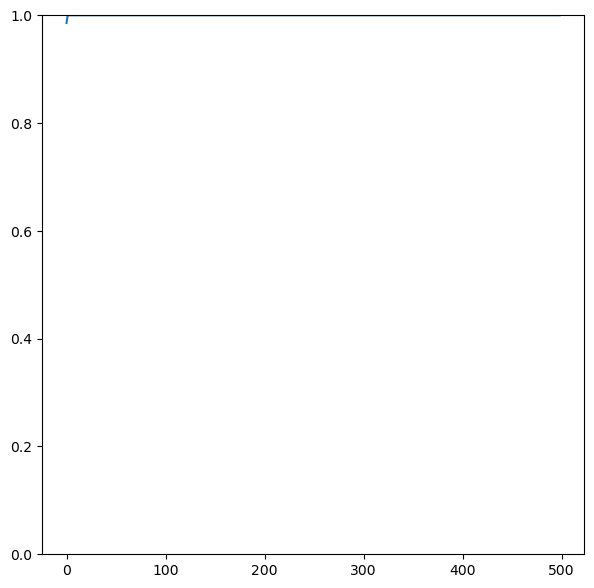

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(scores);
plt.ylim([0, 1]);

## CORUM data

In [ ]:
import pandas as pd

In [ ]:
X = pd.DataFrame({'complexes':complexes, 'names':names}).drop_duplicates()
complex_members = X.groupby('complexes')['names'].apply(list).to_dict()
del complex_members['other']
complex_members = {key: val for key, val in complex_members.items() if len(val) == 2}

In [ ]:
len(complex_members)

21

In [ ]:
pairwise_dist = {}

for k, v in complex_members.items():
    n0, n1 = v
    matches = closest_names[names_train_avg == n0]
    match = np.where(matches == n1)[1]
    
    if len(match) == 0:
        pairwise_dist[k] = np.nan
    else:
        pairwise_dist[k] = match[0]

In [ ]:
pairwise_dist

{'BLM-TRF2 complex': 23,
 'CCDC93-COMMD1-COMMD6 complex': 67,
 'CCNB1-CDC2 complex': 141,
 'CLTC-PI4K2A complex': nan,
 'EIF3 complex (EIF3B, EIF3G, EIF3I)': 1,
 'ESCRT-II complex': 198,
 'ILF3-XPO5 complex': 121,
 'KPNB1-RAN complex': nan,
 'MED18-MED20-MED29 mediator subcomplex': 4,
 'PA28 complex': 9,
 'PAC1-PAC2 complex': 115,
 'PAC3-PAC4 complex': 115,
 'RAB5-EEA1 complex': nan,
 'SF3A1-SF3A2-SF3A3 complex': 1,
 'SLC9A3R1-ACTN4 complex': nan,
 'SNX complex (SNX1, SNX1a, TFRC)': 147,
 'Serine-palmitoyltransferase (SPTLC1, SPTLC2) complex': 297,
 'TOP1-PSF-P54 complex': 6,
 'TSG101-VPS37B-VPS28 complex': 355,
 'ULK1-ATG13-ATG14-PIK3C3 complex': 90,
 'p50-p65 NF(kappa)B-SRC1 complex': nan}

In [ ]:
Z.value_counts()

2    21
1    10
3     6
4     1
dtype: int64

In [ ]:
21 + 3 * 6 + 6

45